In [ ]:
import pandas as pd
import numpy as np
import pyreadstat as prs
import os
from pathlib import Path
import sys

# Change root directory to the repo root (Jupyter: __file__ is not defined)
def find_repo_root(start=Path.cwd()):
	for p in [start] + list(start.parents):
		if (p / 'Code').exists() or (p / '.git').exists() or (p / 'local_repo').exists():
			return p
	return start

repo_root = find_repo_root()
data_root = repo_root.parent.parent / 'Data' / 'CBOS ready'
os.chdir(repo_root)
sys.path.append(str(repo_root / 'Code' / 'tools'))

# import local toolkit (try normal import first, fall back to loading from file)
try:
	import similarity_toolkit_LLM as stk
except Exception:
	import importlib.util
	toolkit_path = repo_root / 'Code' / 'tools' / 'similarity_toolkit_LLM.py'
	if toolkit_path.exists():
		spec = importlib.util.spec_from_file_location("similarity_toolkit_LLM", str(toolkit_path))
		stk = importlib.util.module_from_spec(spec)
		spec.loader.exec_module(stk)
	else:
		raise

In [500]:
path_spss = Path("/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/Data/CBOS SPSS")
list_dir = os.listdir(path_spss)
list_dir = [file for file in list_dir if file.endswith(".sav")]

# Sort by CBOS_XXX where XXX is a number with 1 to 3 digits
list_dir.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

In [501]:
# Load the relevant questions summary
questions_summary = pd.read_csv(Path("/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/local_repo/LRDWI-Paper/relevant_questions_summary.csv"))

# Sort by "spss_file" using the same logic as above
questions_summary['spss_file'] = questions_summary['spss_file'].astype(str)
questions_summary = questions_summary.sort_values(by='spss_file', key=lambda x: x.str.split('_').str[1].str.split('.').str[0].astype(int))

In [502]:
spss_files = questions_summary['spss_file'].unique()
for file in spss_files:
    file_summary = questions_summary[questions_summary['spss_file'] == file]
    if "income_household_per_person" not in file_summary['relevant_key'].values:
        print(file)
    else:
        print(file_summary['matched_question'].values["income_household_per_person" == file_summary['relevant_key'].values])

['Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]']
['Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]'
 'Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]']
CBOS_3_03_1990.sav
CBOS_4_04_1990.sav
CBOS_5_05_1990.sav
CBOS_6_06_1990.sav
CBOS_7_07_1990.sav
CBOS_8_09_1990.sav
CBOS_9_10_1990.sav
CBOS_10_11_1990.sav
CBOS_11_12_1990.sav
CBOS_12_01_1991.sav
CBOS_13_02_1991.sav
CBOS_14_03_1991.sav
CBOS_15_04_1991.sav
CBOS_16_05_1991.sav
CBOS_17_06_1991.sav
CBOS_18_07_1991.sav
CBOS_19_08_1991.sav
CBOS_20_09_1991.sav
CBOS_21_10_1991.sav
CBOS_22_11_1991.sav
CBOS_23_01_1992.sav
['Ile wynoszą W STARYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodarstwie domowym? [tysiące starych złotych]']
['Ile wynoszą W NOWYCH ZŁOTYCH miesięczne dochody na 1 osobę w Pana(i) gospodar- stwie domowym? 

In [503]:
import re

v_lower = np.vectorize(lambda x: x.lower() if isinstance(x, str) else x)
v_compare = np.vectorize(lambda x, y: x == y)
v_contains = np.vectorize(lambda x, y: y in x if isinstance(x, str) and isinstance(y, str) else False)

# Helper function to remove the code of the question from a string
# A code is a number or a code with a letter and number ended with a dot, e.g. "1.", "2a.", "10b.", "M10."
# If the first component of the string is a word, then do not remove anything.
def remove_question_code(s):
    if not isinstance(s, str):
        return s
    parts = s.split()
    if len(parts) == 0:
        return s
    first_part = parts[0]
    # Match patterns like "1.", "10b.", "m10.", "M10."
    if re.fullmatch(r'[A-Za-z]?\d+[A-Za-z]?\.', first_part):
        return ' '.join(parts[1:])
    else:
        return s
    
# Present the functionality of remove_question_code
print(remove_question_code("1. What is your age?"))  # Should return "What is your age?"
print(remove_question_code("m10. How many people live in your household?"))  # Should return "How many people live in your household?"
print(remove_question_code("How are you?"))  # Should return "How are you?"
print(remove_question_code(123))

# Vectorize the function
v_remove_question_code = np.vectorize(remove_question_code)

# Helper function to find a sequence of characters in a string
# For example, to find "doch" in "Ile wynoszą PRZECIĘTNE MIESIĘCZNE DOCHODY NETTO (NA RĘKĘ) PRZYPADAJĄCE NA JEDNĄ OSOBĘ W PANA(I) GOSPODARSTWIE DOMOWYM?"
def contains_sequence(s, seq):
    if not isinstance(s, str) or not isinstance(seq, str):
        return False
    return seq.lower() in s.lower()

# Present the functionality of contains_sequence
print(contains_sequence("Ile wynoszą PRZECIĘTNE MIESIĘCZNE DOCHODY NETTO (NA RĘKĘ) PRZYPADAJĄCE NA JEDNĄ OSOBĘ W PANA(I) GOSPODARSTWIE DOMOWYM?", "doch"))  # Should return True
print(contains_sequence("How are you?", "ar"))  # Should return True
print(contains_sequence("How are you?", "ae"))  # Should return False
print(contains_sequence("Hello world!", "test"))  # Should return False
print(contains_sequence(123, "test"))  # Should return False

What is your age?
How many people live in your household?
How are you?
123
True
True
False
False
False


In [523]:
main_df = pd.DataFrame()

old_age_col = None
old_gender_col = None
old_city_size_col = None
old_location_col = None
st = stk.SimilarityToolkit()

for file in list_dir:
    # Load SPSS file
    df, meta = prs.read_sav(path_spss / file)
    
    # Sub df
    df_sub = pd.DataFrame()
    
    # Add meta info
    df_sub['org_id'] = df[df.columns[0]]
    df_sub['survey file'] = file
    df_sub['survey year'] = int(file[-8:-4])
    df_sub['survey month'] = int(file[-11:-9])
    df_sub['age'] = 0
    
    # Get demographics
    
    col_names = meta.column_names
    col_names = v_lower(col_names)
    
    # Look for age column
    age_col = np.where(v_compare(col_names, 'urodzony'))[0]
    
    # Look for gender column
    gender_col = np.where(v_compare(col_names, 'plec'))[0]
    
    # Look for city size column
    city_size_col = np.where(v_contains(col_names, 'klm'))[0]
    
    # Look for education level column
    education_col = np.where(v_contains(col_names, 'wyksztalcenie'))[0]
    
    # Look for location column
    location_col = np.where(v_contains(col_names, 'woj'))[0]
    
    # Check with relevalnt questions summary
    relevant_questions = questions_summary[questions_summary['spss_file'] == file]
    
    # AGE
    if len(age_col) > 0:
        age_col_name = meta.column_names[age_col[0]]
        df_sub['year_born'] = df[age_col_name]
    else:
        age_col_rq = relevant_questions['relevant_key'] == 'age'
        age_col_rq = relevant_questions[age_col_rq]
        if len(age_col_rq) == 1:
            age_col = np.where(col_names == v_lower(age_col_rq['column_name'].values))[0]            
            age_col_name = meta.column_names[age_col[0]]
            df_sub['year_born'] = df[age_col_name]
        elif len(age_col_rq) > 1:
            age_col_names = age_col_rq['column_name'].values
            age_col_name = age_col_names[1] 
            age_col = np.where(col_names == v_lower(age_col_name))[0]
            age_col_name = meta.column_names[age_col[0]]
            df_sub['year_born'] = df[age_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            age_col = np.where(v_compare(col_labels, 'm2 rok'))[0]
            if len(age_col) == 0:
                age_col = np.where(v_contains(col_labels, '- rok'))[0]
            if len(age_col) == 0:
                age_col = np.where(v_contains(col_labels, 'urodził(a)'))[0]
            if len(age_col) == 0:
                age_col = np.where(v_contains(col_labels, 'rok urodzenia respondenta'))[0]
            age_col_name = meta.column_names[age_col[0]]
            df_sub['year_born'] = df[age_col_name]
    
    # GENDER
    if len(gender_col) > 0:
        gender_col_name = meta.column_names[gender_col[0]]
        df_sub['sex'] = df[gender_col_name]
    else:
        gender_col_rq = relevant_questions['relevant_key'] == 'gender'
        gender_col_rq = relevant_questions[gender_col_rq]
        if len(gender_col_rq) == 1:
            gender_col = np.where(col_names == v_lower(gender_col_rq['column_name'].values))[0]
            gender_col_name = meta.column_names[gender_col[0]]
            df_sub['sex'] = df[gender_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            gender_col = np.where(v_contains(col_labels, 'm1.'))[0]
            if len(gender_col) == 0 or (len(gender_col) > 0 and "płeć" not in col_labels[gender_col[0]]):
                gender_col = np.where(v_contains(col_labels, 'płeć'))[0]
            if len(gender_col) == 0:
                gender_col = np.where(v_contains(col_labels, 'płęć'))[0]
            if len(gender_col) > 1:
                print(f"Warning: multiple gender columns found in {file}.")
            gender_col_name = meta.column_names[gender_col[0]]
            if file == "CBOS_203_04_2007.sav":
                gender_col_name = "M1PLEC"
            df_sub['sex'] = df[gender_col_name]
            
    # Map gender labels
    gender_labels_dict = meta.value_labels[meta.variable_to_label[gender_col_name]]
    df_sub['sex_L'] = ''
    for key, value in gender_labels_dict.items():
        df_sub.loc[df_sub['sex'] == key, 'sex_L'] = value
    
    # CITY SIZE
    if len(city_size_col) > 0:
        city_size_col_name = meta.column_names[city_size_col[0]]
        df_sub['city_size'] = df[city_size_col_name]
    else:
        city_size_col_rq = relevant_questions['relevant_key'] == 'city_size'
        city_size_col_rq = relevant_questions[city_size_col_rq]
        if len(city_size_col_rq) == 1:
            city_size_col = np.where(col_names == v_lower(city_size_col_rq['column_name'].values))[0]
            city_size_col_name = meta.column_names[city_size_col[0]]
            df_sub['city_size'] = df[city_size_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            city_size_col = np.where(v_contains(col_labels, 'czy miejscowość'))[0]
            if len(city_size_col) == 0:
                city_size_col = np.where(v_contains(col_labels, 'miejscowość'))[0]
            if "221_10_2008" in file:
                city_size_col_name = 'q7'
            elif "266_07_2012" in file or "268_09_2012" in file:
                city_size_col_name = ''
            else:
                city_size_col_name = meta.column_names[city_size_col[0]]
                
            if len(city_size_col) > 1:
                print(f"Warning: multiple city size columns found in {file}.")
                
            if city_size_col_name != '':
                df_sub['city_size'] = df[city_size_col_name]
            else:
                df_sub['city_size'] = np.nan
    
    # Map city size labels
    if city_size_col_name != '':
        city_size_labels_dict = meta.value_labels[meta.variable_to_label[city_size_col_name]]
        df_sub['city_size_L'] = ''
        for key, value in city_size_labels_dict.items():
            df_sub.loc[df_sub['city_size'] == key, 'city_size_L'] = value
    else:
        df_sub['city_size_L'] = np.nan
    
    # EDUCATION LEVEL
    if len(education_col) > 0:
        education_col_name = meta.column_names[education_col[0]]
        df_sub['education'] = df[education_col_name]
    else:
        education_col_rq = relevant_questions['relevant_key'] == 'education'
        education_col_rq = relevant_questions[education_col_rq]
        if len(education_col_rq) == 1:
            education_col = np.where(col_names == v_lower(education_col_rq['column_name'].values))[0]
            education_col_name = meta.column_names[education_col[0]]
            df_sub['education'] = df[education_col_name]
        else:
            col_labels = meta.column_labels
            col_labels = v_lower(col_labels)
            education_col = np.where(v_contains(col_labels, 'm3.'))[0]
            if len(education_col) == 0 or (len(education_col) > 0 and "wykształcenie" not in col_labels[education_col[0]]):
                education_col = np.where(v_contains(col_labels, 'm6.'))[0]
            if len(education_col) == 0 or (len(education_col) > 0 and "wykształcenie" not in col_labels[education_col[0]]):
                education_col = np.where(v_contains(col_labels, 'wykształcenie'))[0]
            if len(education_col) == 0 or ("10_2013" in file) or ("11_2013" in file):
                education_col = np.where(v_contains(col_labels, 'poziom wykształcenia'))[0]
            if len(education_col) > 1:
                print(f"Warning: multiple education level columns found in {file}.")
            education_col_name = meta.column_names[education_col[0]]
            df_sub['education'] = df[education_col_name]
    
    # Map education level labels
    education_labels_dict = meta.value_labels[meta.variable_to_label[education_col_name]]
    df_sub['education_L'] = ''
    for key, value in education_labels_dict.items():
        df_sub.loc[df_sub['education'] == key, 'education_L'] = value
    
    # LOCATION
    df_sub['location_new'] = 0
    df_sub['location_old'] = 0
    df_sub['location_new_L'] = ''
    df_sub['location_old_L'] = ''
    
    col_labels = meta.column_labels
    col_labels = v_lower(col_labels)
    location_col = np.where(v_compare(col_labels, 'województwo'))[0]
    if len(location_col) != 1:
        location_col = np.where(v_contains(col_labels, 'województwo'))[0]
    if len(location_col) == 1:
        location_col_name = meta.column_names[location_col[0]]
        if df_sub['survey year'].values[0] < 1999:
            df_sub['location_old'] = df[location_col_name]
            location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
            for key, value in location_labels_dict.items():
                df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
        else:
            df_sub['location_new'] = df[location_col_name]
            if "140_01_2002" not in file:
                location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
            for key, value in location_labels_dict.items():
                df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
    else:
        if len(location_col) == 0:
            location_col = np.where(v_contains(col_labels, 'województwa'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_contains(col_labels, 'aneks woj'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_contains(col_labels, 'wojewodztwo'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_compare(col_labels, 'woj.nowe'))[0]
            if len(location_col) == 0:
                location_col = np.where(v_compare(col_labels, 'makroregion'))[0]
            
            if len(location_col) == 1:
                location_col_name = meta.column_names[location_col[0]]
                if df_sub['survey year'].values[0] < 1999:
                    df_sub['location_old'] = df[location_col_name]
                    location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
                    for key, value in location_labels_dict.items():
                        df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
                else:
                    location_labels_dict = meta.value_labels[meta.variable_to_label[location_col_name]]
                    if len(location_labels_dict) > 20:
                        df_sub['location_old'] = df[location_col_name]
                        for key, value in location_labels_dict.items():
                            df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
                    else:
                        df_sub['location_new'] = df[location_col_name]
                        for key, value in location_labels_dict.items():
                            df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
            else:
                location_col_names = [meta.column_labels[i] for i in location_col]
                location_old_col_name = np.where(v_contains(v_lower(location_col_names), 'stare'))[0]
                location_new_col_name = np.where(v_contains(v_lower(location_col_names), 'nowe'))[0]
                location_old_col = np.where(v_compare(location_col, location_col[location_old_col_name[0]]))[0]
                location_new_col = np.where(v_compare(location_col, location_col[location_new_col_name[0]]))[0]
                
                df_sub['location_old'] = df[meta.column_names[location_col[location_old_col[0]]]]
                location_labels_dict_old = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_old_col[0]]]]]
                for key, value in location_labels_dict_old.items():
                    df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
                df_sub['location_new'] = df[meta.column_names[location_col[location_new_col[0]]]]
                location_labels_dict_new = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_new_col[0]]]]]
                for key, value in location_labels_dict_new.items():
                    df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
        else:
            location_col_names = [meta.column_labels[i] for i in location_col]
            location_old_col_name = np.where(v_contains(v_lower(location_col_names), 'stare'))[0]
            location_new_col_name = np.where(v_contains(v_lower(location_col_names), 'nowe'))[0]
            location_old_col = np.where(v_compare(location_col, location_col[location_old_col_name[0]]))[0]
            location_new_col = np.where(v_compare(location_col, location_col[location_new_col_name[0]]))[0]
            
            df_sub['location_old'] = df[meta.column_names[location_col[location_old_col[0]]]]
            location_labels_dict_old = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_old_col[0]]]]]
            for key, value in location_labels_dict_old.items():
                df_sub.loc[df_sub['location_old'] == key, 'location_old_L'] = value
            df_sub['location_new'] = df[meta.column_names[location_col[location_new_col[0]]]]
            location_labels_dict_new = meta.value_labels[meta.variable_to_label[meta.column_names[location_col[location_new_col[0]]]]]
            for key, value in location_labels_dict_new.items():
                df_sub.loc[df_sub['location_new'] == key, 'location_new_L'] = value
    
    # HH SIZE
    hh_size_col = relevant_questions['relevant_key'] == 'household_size'
    hh_size_col = relevant_questions[hh_size_col]
    hh_size_col_name = hh_size_col['column_name'].values
    if len(hh_size_col_name) == 0:
        col_labels = meta.column_labels
        col_labels = v_lower(col_labels)
        #print(col_labels)
        hh_size_col = np.where(v_contains(col_labels, 'z ilu osób'))[0]
        if len(hh_size_col) > 0:
            hh_size_col_name = meta.column_names[hh_size_col[0]]
            df_sub['household_size'] = df[hh_size_col_name]
        else:
            df_sub['household_size'] = np.nan
            print(f"Warning: household size column not found in {file}.")
    elif len(hh_size_col_name) > 1 and "281_10_2013" in file:
        hh_size_col_name = hh_size_col_name[1]
        df_sub['household_size'] = df[hh_size_col_name]
    elif len(hh_size_col_name) > 2 and "282_11_2013" in file:
        hh_size_col_name = hh_size_col_name[2]
        df_sub['household_size'] = df[hh_size_col_name]
    else:
        df_sub['household_size'] = df[hh_size_col_name]
    
    # HH INCOME
    # Initialize income columns
    df_sub['income_hh_OLD'] = 0
    df_sub['income_hh_NEW'] = 0
    df_sub['income_hh'] = 0
    
    df_sub['income_hh_OLD_L'] = ""
    df_sub['income_hh_NEW_L'] = ""
    df_sub['income_hh_L'] = ""
    
    df_sub['income_hh_OLD_T'] = 0
    df_sub['income_hh_NEW_T'] = 0
    df_sub['income_hh_T'] = 0
    
    df_sub['income_hh_OLD_T_L'] = ""
    df_sub['income_hh_NEW_T_L'] = ""
    df_sub['income_hh_T_L'] = ""
    
    df_sub['income_p_OLD'] = 0
    df_sub['income_p_NEW'] = 0
    df_sub['income_p'] = 0
    
    df_sub['income_p_OLD_L'] = ""
    df_sub['income_p_NEW_L'] = ""
    df_sub['income_p_L'] = ""
    
    df_sub['income_p_OLD_T'] = 0
    df_sub['income_p_NEW_T'] = 0
    df_sub['income_p_T'] = 0
    
    df_sub['income_p_OLD_T_L'] = ""
    df_sub['income_p_NEW_T_L'] = ""
    df_sub['income_p_T_L'] = ""
    
    col_labels = meta.column_labels
    col_labels = v_lower(col_labels)
    col_labels_removed_labels = v_remove_question_code(col_labels)
    q = "Ile wynoszą PRZECIĘTNE MIESIĘCZNE DOCHODY NETTO (NA RĘKĘ) PRZYPADAJĄCE NA JEDNĄ OSOBĘ W PANA(I) GOSPODARSTWIE DOMOWYM?".lower()
    sim_vect = []

    k = 0
    for label in col_labels_removed_labels:
        if not col_labels[k].startswith("m") and (not df_sub['survey year'].values[0] in [2006, 2007, 2008]):
            sim_vect.append(-1)
            k += 1
            continue
        if "pomocnicza" in label or 'powinny' in label or 'respondenta' in label:
            sim_vect.append(-1)
            k += 1
            continue
        if df_sub['survey year'].values[0] == 2016 and 'a czy' in label:
            sim_vect.append(-1)
            k += 1
            continue
        sim = st.similarity(q, label)
        sim_vect.append(sim['score'])
        k += 1
    # Print the questions with the highest similarity
    sim_vect = np.array(sim_vect)
    income_col = np.where(sim_vect == np.max(sim_vect))[0]
    income_col_name = meta.column_names[income_col[0]]
    income_col_label = col_labels[income_col[0]]
    
    print(meta.column_names[income_col[0]])
    print(f"Max similarity for income question in {file}: {col_labels[income_col[0]]} (sim={sim_vect[income_col[0]]})")
    
    if "kwotę" in col_labels[income_col[0]+1] or "kwota" in col_labels[income_col[0]+1]:
        income_col_name = meta.column_names[income_col[0]+1]
        # income_col_label = col_labels[income_col[0]+1]
        income_col[0] = income_col[0]+1
        print(f"Adjusted income column to: {income_col_name} with label: {income_col_label}")
    
    if df_sub['survey year'].values[0] == 2008 and df_sub['survey month'].values[0] == 9:
        income_col_name = "q76"
        income_col_label = meta.column_labels[np.where(np.array(meta.column_names) == income_col_name)[0][0]]

    values = df[income_col_name].values
    # Convert to numeric and remove NaNs
    values = pd.to_numeric(values, errors='coerce')
    values = values[~np.isnan(values)]

    
    if df_sub['survey year'].values[0] < 1995 or contains_sequence(income_col_label, "starych"):
        if np.max(values) < 100:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_OLD_T'] = df[income_col_name]
                df_sub['income_hh_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_hh_OLD_T'] == key, 'income_hh_OLD_T_L'] = value
                    df_sub.loc[df_sub['income_hh_T'] == key, 'income_hh_T_L'] = value
            else:
                df_sub['income_p_OLD_T'] = df[income_col_name]
                df_sub['income_p_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_p_OLD_T'] == key, 'income_p_OLD_T_L'] = value
                    df_sub.loc[df_sub['income_p_T'] == key, 'income_p_T_L'] = value
        else:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_OLD'] = df[income_col_name]
                df_sub['income_hh'] = df[income_col_name]/10
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_hh_OLD'] == key, 'income_hh_OLD_L'] = value
                        df_sub.loc[df_sub['income_hh']*10 == key, 'income_hh_L'] = value
                except KeyError:
                    pass
            else:
                df_sub['income_p_OLD'] = df[income_col_name]
                df_sub['income_p'] = df[income_col_name]/10
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_p_OLD'] == key, 'income_p_OLD_L'] = value
                        df_sub.loc[df_sub['income_p']*10 == key, 'income_p_L'] = value
                except KeyError:
                    pass
    else:
        if np.max(values) < 100:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_NEW_T'] = df[income_col_name]
                df_sub['income_hh_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_hh_NEW_T'] == key, 'income_hh_NEW_T_L'] = value
                    df_sub.loc[df_sub['income_hh_T'] == key, 'income_hh_T_L'] = value
            else:
                df_sub['income_p_NEW_T'] = df[income_col_name]
                df_sub['income_p_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_p_NEW_T'] == key, 'income_p_NEW_T_L'] = value
                    df_sub.loc[df_sub['income_p_T'] == key, 'income_p_T_L'] = value
        else:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_NEW'] = df[income_col_name]
                df_sub['income_hh'] = df[income_col_name]
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_hh_NEW'] == key, 'income_hh_NEW_L'] = value
                        df_sub.loc[df_sub['income_hh'] == key, 'income_hh_L'] = value
                except KeyError:
                    pass
            else:
                df_sub['income_p_NEW'] = df[income_col_name]
                df_sub['income_p'] = df[income_col_name]
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_p_NEW'] == key, 'income_p_NEW_L'] = value
                        df_sub.loc[df_sub['income_p'] == key, 'income_p_L'] = value
                except KeyError:
                    pass
    '''
    q = "Ile wynoszą PANA(I) MIESIĘCZNE DOCHODY NETTO (NA RĘKĘ)?".lower()
    sim_vect = []

    k = 0
    for label in col_labels_removed_labels:
        if not col_labels[k].startswith("m") and (not df_sub['survey year'].values[0] in [2006, 2007, 2008]):
            sim_vect.append(-1)
            k += 1
            continue
        if "pomocnicza" in label or 'powinny' in label:
            sim_vect.append(-1)
            k += 1
            continue
        sim = st.similarity(q, label)
        sim_vect.append(sim['score'])
        k += 1
    # Print the questions with the highest similarity
    sim_vect = np.array(sim_vect)
    income_col = np.where(sim_vect == np.max(sim_vect))[0]
    income_col_name = meta.column_names[income_col[0]]
    income_col_label = col_labels[income_col[0]]
    
    print(meta.column_names[income_col[0]])
    print(f"Max similarity for income question in {file}: {col_labels[income_col[0]]} (sim={sim_vect[income_col[0]]})")
    
    if "kwotę" in col_labels[income_col[0]+1] or "kwota" in col_labels[income_col[0]+1]:
        income_col_name = meta.column_names[income_col[0]+1]
        # income_col_label = col_labels[income_col[0]+1]
        income_col[0] = income_col[0]+1
        print(f"Adjusted income column to: {income_col_name} with label: {income_col_label}")

    values = df[income_col_name].values
    # Convert to numeric and remove NaNs
    values = pd.to_numeric(values, errors='coerce')
    values = values[~np.isnan(values)]

    
    if df_sub['survey year'].values[0] < 1995 or contains_sequence(income_col_label, "starych"):
        if np.max(values) < 100:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_OLD_T'] = df[income_col_name]
                df_sub['income_hh_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_hh_OLD_T'] == key, 'income_hh_OLD_T_L'] = value
                    df_sub.loc[df_sub['income_hh_T'] == key, 'income_hh_T_L'] = value
            else:
                df_sub['income_p_OLD_T'] = df[income_col_name]
                df_sub['income_p_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_p_OLD_T'] == key, 'income_p_OLD_T_L'] = value
                    df_sub.loc[df_sub['income_p_T'] == key, 'income_p_T_L'] = value
        else:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_OLD'] = df[income_col_name]
                df_sub['income_hh'] = df[income_col_name]/10
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_hh_OLD'] == key, 'income_hh_OLD_L'] = value
                        df_sub.loc[df_sub['income_hh']*10 == key, 'income_hh_L'] = value
                except KeyError:
                    pass
            else:
                df_sub['income_p_OLD'] = df[income_col_name]
                df_sub['income_p'] = df[income_col_name]/10
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_p_OLD'] == key, 'income_p_OLD_L'] = value
                        df_sub.loc[df_sub['income_p']*10 == key, 'income_p_L'] = value
                except KeyError:
                    pass
    else:
        if np.max(values) < 100:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_NEW_T'] = df[income_col_name]
                df_sub['income_hh_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_hh_NEW_T'] == key, 'income_hh_NEW_T_L'] = value
                    df_sub.loc[df_sub['income_hh_T'] == key, 'income_hh_T_L'] = value
            else:
                df_sub['income_p_NEW_T'] = df[income_col_name]
                df_sub['income_p_T'] = df[income_col_name]
                income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                for key, value in income_labels_dict.items():
                    df_sub.loc[df_sub['income_p_NEW_T'] == key, 'income_p_NEW_T_L'] = value
                    df_sub.loc[df_sub['income_p_T'] == key, 'income_p_T_L'] = value
        else:
            if contains_sequence(income_col_label, "osob"):
                df_sub['income_hh_NEW'] = df[income_col_name]
                df_sub['income_hh'] = df[income_col_name]
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_hh_NEW'] == key, 'income_hh_NEW_L'] = value
                        df_sub.loc[df_sub['income_hh'] == key, 'income_hh_L'] = value
                except KeyError:
                    pass
            else:
                df_sub['income_p_NEW'] = df[income_col_name]
                df_sub['income_p'] = df[income_col_name]
                try:
                    income_labels_dict = meta.value_labels[meta.variable_to_label[income_col_name]]
                    for key, value in income_labels_dict.items():
                        df_sub.loc[df_sub['income_p_NEW'] == key, 'income_p_NEW_L'] = value
                        df_sub.loc[df_sub['income_p'] == key, 'income_p_L'] = value
                except KeyError:
                    pass
                
    '''
    
    # WAGA
    df_sub['weight'] = 1.0
    col_names = meta.column_names
    col_names = v_lower(col_names)
    weight_col = np.where(v_compare(col_names, 'waga'))[0]
        
    if len(weight_col) > 0:
        weight_col_name = meta.column_names[weight_col[0]]
        df_sub['weight'] = df[weight_col_name]
    else:
        col_labels = meta.column_labels
        col_labels = v_lower(col_labels)
        weight_col = np.where(v_contains(col_labels, 'waga'))[0]
        if len(weight_col) == 1:
            weight_col_name = meta.column_names[weight_col[0]]
            df_sub['weight'] = df[weight_col_name]
        elif len(weight_col) > 1:
            weight_col_names = [meta.column_names[i] for i in weight_col]
            # Take the one which contains on average smallest values
            min_avg = np.inf
            selected_col_name = weight_col_names[0]
            for col_name in weight_col_names:
                avg = np.nanmean(pd.to_numeric(df[col_name], errors='coerce'))
                if avg < min_avg:
                    min_avg = avg
                    selected_col_name = col_name
            df_sub['weight'] = df[selected_col_name]
        else:
            print(f"Warning: weight column not found in {file}.")
    
    # For surveys before 1993, set weight to 1.0
    if df_sub['survey year'].values[0] < 1993:
        df_sub['weight'] = 1.0
    
    main_df = pd.concat([main_df, df_sub], ignore_index=True)
    

[LLM Downloader] Using existing local model at /Users/jedrek/.cache/similarity_toolkit/sentence-transformers--paraphrase-multilingual-mpnet-base-v2
q264
Max similarity for income question in CBOS_1_01_1990.sav: m11. ile wynosi średni miesięczny dochód na jedną osobę w pana(i) gospodarstwie domowym? (sim=0.9889117479324341)
q185
Max similarity for income question in CBOS_2_02_1990.sav: m11. ile wynosi średni miesięczny dochód na jedną osobę w pana(i) gospodarstwie domowym? [tysiące starych złotych] (sim=0.9856968522071838)
q206
Max similarity for income question in CBOS_3_03_1990.sav: m9. ile wyniósł dochód na jedną osobę w pana(i) gospodarstwie domowym w lutym? [tysiące starych złotych] (sim=0.9003711342811584)
q180
Max similarity for income question in CBOS_4_04_1990.sav: m9. ile wyniósł dochód na jedną osobę w pana(i) gospodarstwie domowym w marcu? [w tysiącach starych złotych] (sim=0.9043700098991394)
q218
Max similarity for income question in CBOS_5_05_1990.sav: m11. ile wyniósł do

In [ ]:
# Save the main_df to a csv file
main_df.to_csv(data_root / 'CBOS_data.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
# Load the saved csv file to verify
df_loaded = pd.read_csv(data_root / 'CBOS_data.csv')

/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_48816/846455166.py:3: DtypeWarning: Columns (14,15,20,21,22,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loaded = pd.read_csv(repo_root / 'CBOS_data.csv')


In [526]:
df_loaded

,org_id,survey file,survey year,survey month,age,year_born,sex,sex_L,city_size,city_size_L,...,income_p_OLD_L,income_p_NEW_L,income_p_L,income_p_OLD_T,income_p_NEW_T,income_p_T,income_p_OLD_T_L,income_p_NEW_T_L,income_p_T_L,weight
0,1.0,CBOS_1_01_1990.sav,1990,1,0,1957.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
1,2.0,CBOS_1_01_1990.sav,1990,1,0,1950.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
2,3.0,CBOS_1_01_1990.sav,1990,1,0,1932.0,2.0,Kobieta,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
3,4.0,CBOS_1_01_1990.sav,1990,1,0,1946.0,1.0,Mężczyzna,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
4,5.0,CBOS_1_01_1990.sav,1990,1,0,1939.0,1.0,Mężczyzna,9.0,Miasto powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358520,921.0,CBOS_331_12_2017.sav,2017,12,0,1957.0,1.0,Mężczyzna,1.0,wieś,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,0.611965
358521,922.0,CBOS_331_12_2017.sav,2017,12,0,1981.0,1.0,Mężczyzna,1.0,wieś,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.127158
358522,923.0,CBOS_331_12_2017.sav,2017,12,0,1976.0,1.0,Mężczyzna,5.0,miasto od 100 000 do 499 999,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.716070
358523,924.0,CBOS_331_12_2017.sav,2017,12,0,1971.0,2.0,Kobieta,5.0,miasto od 100 000 do 499 999,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.572886


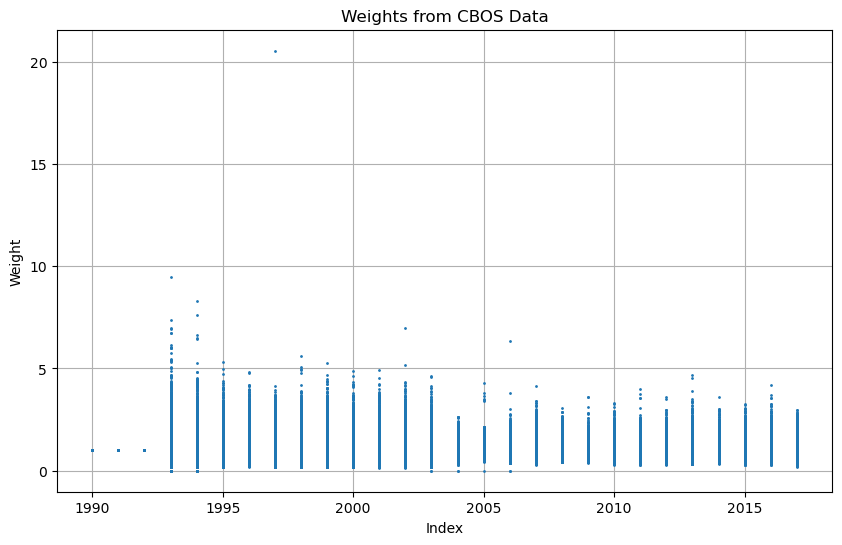

In [527]:
# Basic check of weights

weight = df_loaded['weight'].values
years = df_loaded['survey year'].values
# Plot the weights wrt index

plt.figure(figsize=(10, 6))
plt.plot(years, weight, marker='.', linestyle='', markersize=2)
plt.title('Weights from CBOS Data')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

    

In [528]:
# Weights > 10 check
weights_above_10 = df_loaded[df_loaded['weight'] > 10]
display(weights_above_10)

,org_id,survey file,survey year,survey month,age,year_born,sex,sex_L,city_size,city_size_L,...,income_p_OLD_L,income_p_NEW_L,income_p_L,income_p_OLD_T,income_p_NEW_T,income_p_T,income_p_OLD_T_L,income_p_NEW_T_L,income_p_T_L,weight
95871,540.0,CBOS_81_02_1997.sav,1997,2,0,1926.0,1.0,Mężczyzna,2.0,Miastem: poniżej 20 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,20.535356


In [ ]:
# Weights > 5 check
weights_above_5 = df_loaded[df_loaded['weight'] > 5]
display(weights_above_5)

,org_id,survey file,survey year,survey month,age,year_born,sex,sex_L,city_size,city_size_L,...,income_p_OLD_L,income_p_NEW_L,income_p_L,income_p_OLD_T,income_p_NEW_T,income_p_T,income_p_OLD_T_L,income_p_NEW_T_L,income_p_T_L,weight
39790,891.0,CBOS_31_01_1993.sav,1993,1,0,1934.0,1.0,Mężczyzna,4.0,miastem od 100 do 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,7.353050
39808,909.0,CBOS_31_01_1993.sav,1993,1,0,1938.0,2.0,Kobieta,5.0,miastem powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,5.423145
39932,1033.0,CBOS_31_01_1993.sav,1993,1,0,1934.0,2.0,Kobieta,4.0,miastem od 100 do 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,6.947926
41813,470.0,CBOS_33_03_1993.sav,1993,3,0,1959.0,1.0,Mężczyzna,4.0,miastem od 100 do 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,5.024940
41827,484.0,CBOS_33_03_1993.sav,1993,3,0,1949.0,2.0,Kobieta,2.0,miastem poniżej 20 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,5.073473
42056,713.0,CBOS_33_03_1993.sav,1993,3,0,1950.0,2.0,Kobieta,5.0,miastem powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,6.757991
42635,64.0,CBOS_34_04_1993.sav,1993,4,0,1967.0,1.0,Mężczyzna,5.0,miastem powyżej 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,5.995399
43296,725.0,CBOS_34_04_1993.sav,1993,4,0,1968.0,2.0,Kobieta,3.0,miastem od 20 do 100 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,5.424475
43309,738.0,CBOS_34_04_1993.sav,1993,4,0,1959.0,1.0,Mężczyzna,4.0,miastem od 100 do 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,9.492831
44048,401.0,CBOS_35_05_1993.sav,1993,5,0,1934.0,1.0,Mężczyzna,4.0,od 100 do 500 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,6.061260


In [533]:
# Now we deal with specific entries of the income columns if needed

for id, row in df_loaded.iterrows():
    # Example: If income_hh is greater than 10000, set it to NaN
    if row['income_hh'] < 0:
        df_loaded.at[id, 'income_hh'] = np.nan
    if row['income_hh_L'] is not np.nan and str(row['income_hh']).startswith('999'):
        if not str(row['income_hh']).endswith('1'):
            df_loaded.at[id, 'income_hh'] = np.nan
    
    if row['income_hh_OLD'] < 0:
        df_loaded.at[id, 'income_hh_OLD'] = np.nan
    if row['income_hh_OLD_L'] is not np.nan and str(row['income_hh_OLD']).startswith('999'):
        if not str(row['income_hh_OLD']).endswith('1'):
            df_loaded.at[id, 'income_hh_OLD'] = np.nan
    
    if row['income_hh_NEW'] < 0:
        df_loaded.at[id, 'income_hh_NEW'] = np.nan
    if row['income_hh_NEW_L'] is not np.nan and str(row['income_hh_NEW']).startswith('999'):
        if not str(row['income_hh_NEW']).endswith('1'):
            df_loaded.at[id, 'income_hh_NEW'] = np.nan
            
        

In [ ]:
df_loaded.to_csv(data_root / 'CBOS_data_cleaned.csv', index=False)